# P04: Maximum likelihood methods

In this challenge, we are going to study the determination of photometric redshifts in galaxy surveys. 

Galaxy redshifts are usually determined by comparing the observed galaxy spectrum to templates and inferring the redshift from the observed wavelength shift of the observed spectrum. Redshifts determined in this way are called *spectroscopic redshifts*. 

Since taking galaxy spectra is time-consuming, large surveys usually cannot afford to measure the full galaxy spectrum, but only the observed flux in discrete wavelength bands. Such photometric galaxy redshifts are then inferred by comparing the observed integrated flux in these bands to that expected for different templates. 

Photometric redshifts are more noisy (and more prone to biases) than spectroscopic ones, but since they require less observing time, photometric surveys are able to observe much larger galaxy numbers. This is particularly important for surveys focused on weak gravitational lensing, as for example the recently completed [Dark Energy Survey (DES)](https://www.darkenergysurvey.org/). The photometric bands for DES cover the visible and a bit of the infrared spectrum and are shown in the figure below.

In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

Text(0.5, 1.0, 'DES transmission curves')

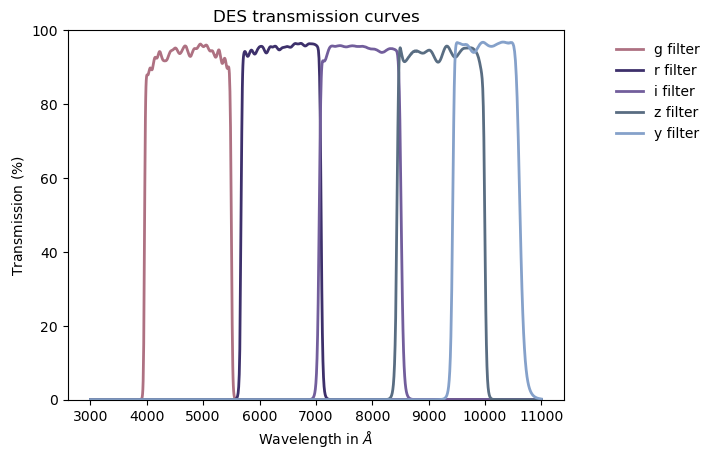

In [3]:
des_g = np.loadtxt('data/DES_g.txt', skiprows = 1)
des_r = np.loadtxt('data/DES_r.txt', skiprows = 1)
des_i = np.loadtxt('data/DES_i.txt', skiprows = 1)
des_z = np.loadtxt('data/DES_z.txt', skiprows = 1)
des_y = np.loadtxt('data/DES_y.txt', skiprows = 1)
plt.plot(des_g.T[0]*10,des_g.T[1], label = 'g filter', color='#AE7182', linewidth=2)
plt.plot(des_r.T[0]*10,des_r.T[1], label = 'r filter', color='#3d306b', linewidth=2)
plt.plot(des_i.T[0]*10,des_i.T[1], label = 'i filter', color='#725e9c', linewidth=2)
plt.plot(des_z.T[0]*10,des_z.T[1], label = 'z filter', color='#596d82', linewidth=2)
plt.plot(des_y.T[0]*10,des_y.T[1], label = 'y filter', color='#85a1ca', linewidth=2)
plt.xlabel(r'Wavelength in $\AA$')
plt.ylabel(r'Transmission $(\%)$')
plt.ylim(0, 100)
plt.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.3, 1.))
plt.title('DES transmission curves')

We will simplify things a bit by assuming DES-like filters that either transmit nothing or the full signal. The filter properties are stored in `bandfilters.txt` and shown as grey bands in the following plot.

Text(0.5, 1.0, 'DES transmission curves')

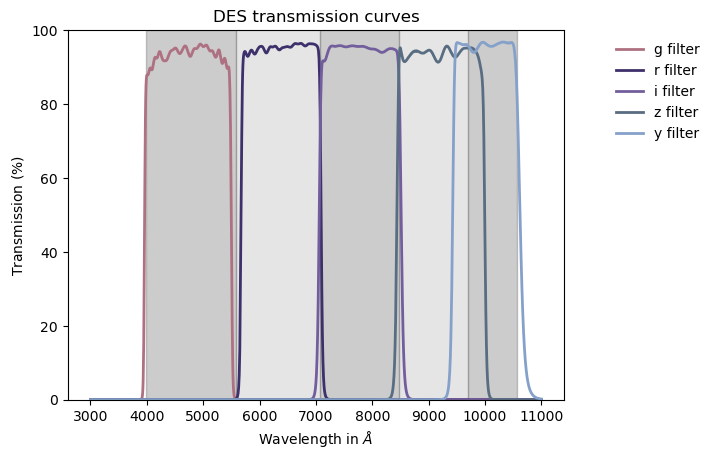

In [4]:
filters = np.loadtxt('data/bandfilters.txt')
plt.axvspan(filters[0], filters[1], alpha = .2, color = 'k', zorder=-1)
plt.axvspan(filters[1], filters[2], alpha = .1, color = 'k', zorder=-1)
plt.axvspan(filters[2], filters[3], alpha = .2, color = 'k', zorder=-1)
plt.axvspan(filters[3], filters[4], alpha = .1, color = 'k', zorder=-1)
plt.axvspan(filters[4], filters[5], alpha = .2, color = 'k', zorder=-1)
plt.plot(des_g.T[0]*10,des_g.T[1], label = 'g filter', color='#AE7182', linewidth=2)
plt.plot(des_r.T[0]*10,des_r.T[1], label = 'r filter', color='#3d306b', linewidth=2)
plt.plot(des_i.T[0]*10,des_i.T[1], label = 'i filter', color='#725e9c', linewidth=2)
plt.plot(des_z.T[0]*10,des_z.T[1], label = 'z filter', color='#596d82', linewidth=2)
plt.plot(des_y.T[0]*10,des_y.T[1], label = 'y filter', color='#85a1ca', linewidth=2)
plt.xlabel(r'Wavelength in $\AA$')
plt.ylabel(r'Transmission $(\%)$')
plt.ylim(0, 100)
plt.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.3, 1.))
plt.title('DES transmission curves')

Let us assume, we have a galaxy with an observed (i.e. at the telescope) spectrum $I(\lambda)$ as shown below. 

Text(0, 0.5, 'Flux')

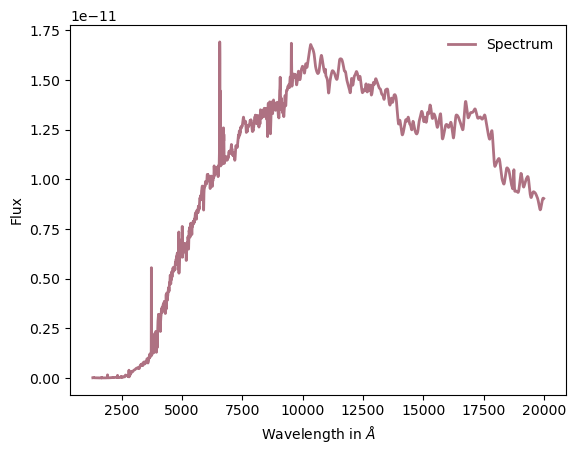

In [5]:
path = "data/k_nmf_derived.newdefault.fits"
temps = fits.open(path)
tspec = temps[1].data
lam = temps[11].data
template = tspec[0]
plt.plot(lam, template, label = 'Spectrum', color='#AE7182', linewidth=2)
plt.legend(frameon=False, loc = 0)
plt.xlabel(r'Wavelength in $\AA$')
plt.ylabel(r'Flux')

A photometric survey will now measure the integrated flux over its photometric bands. Usually, these fluxes are normalized, and here we just take them as the mean flux over the photometric band, see below:

Text(0, 0.5, 'Flux')

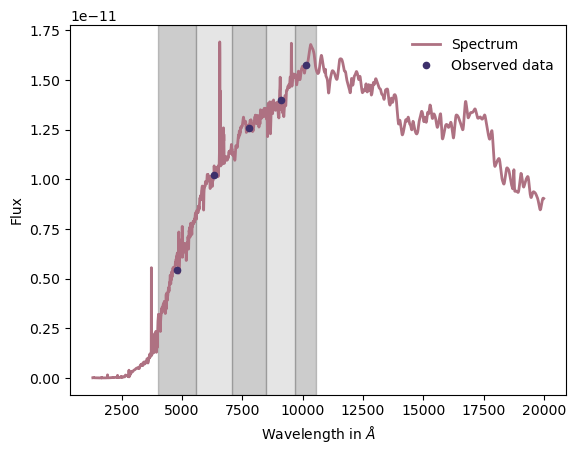

In [6]:
data = np.zeros(5)
for i in range(5):
    inds = np.logical_and(lam > filters[i], lam < filters[i+1])
    data[i] = template[inds].mean()
mufilters = (filters[1:] + filters[:-1]) * .5
plt.plot(lam, template, label = 'Spectrum', color='#AE7182', linewidth=2)
plt.plot(mufilters, data, marker='.', markersize=9, linestyle='None', \
         color='#3d306b', label = 'Observed data')
plt.axvspan(filters[0], filters[1], alpha = .2, color = 'k', zorder=-1)
plt.axvspan(filters[1], filters[2], alpha = .1, color = 'k', zorder=-1)
plt.axvspan(filters[2], filters[3], alpha = .2, color = 'k', zorder=-1)
plt.axvspan(filters[3], filters[4], alpha = .1, color = 'k', zorder=-1)
plt.axvspan(filters[4], filters[5], alpha = .2, color = 'k', zorder=-1)
plt.legend(frameon=False, loc = 0)
plt.xlabel(r'Wavelength in $\AA$')
plt.ylabel(r'Flux')

## Problem 1: Finding the best-fit template spectrum amplitude

Let us assume that in restframe, all galaxies have a spectrum as the one given in `tspec[0]` but they vary in their total luminosity. Observationally we measure galaxy magnitudes, i.e. the logarithm of observed galaxy fluxes, in the five photometric bands given above. 

In this first problem, we will assume that we do not have a model for the measurement errors on galaxy magnitudes. As a first guess, we can therefore assume that the magnitudes (i.e. the log of the flux) are Gaussian-distributed with equal errors in each photometric band. Allowing for a variable galaxy luminosity in this model amounts to introducing a constant amplitude $A$ that consistently scales the model log-fluxes in all photometric bands.

(i) Write down an analytic expression for the likelihood that needs to be minimzed to find the best-fit amplitude $A$ for a given galaxy.

(ii) Assume that a galaxy at redshift $z=0$ yields the measured fluxes in our five photometric bands given in `galaxy_fluxes_z=0.txt`. Use the expression of the likelihood you have derived to determine the amplitude of the template log-fluxes that best fits the observations. 

## Problem 2: Photometric redshifts without error model

We now extend our model from problem 1 to determine galaxy redshifts: we can estimate a galaxy's redshift by solving the maximum likelihood problem from our first exercise on a grid of redshifts. The redshift which corresponds to the solution with the smallest residuals is our maximum-likelihood redshift estimate for the galaxy.

(i) Estimate the redshift of all galaxies in catalog `catalog1.txt`, assuming that all galaxies are of type `tspec[0]` and that their redshifts lie between $0 \leq z \leq 1.5$. 

(ii) Verify your results with the true redshifts in `redshifts1.txt`.

## Problem 3: Photometric redshifts with error model

Let us now assume that we have a model for our errors, i.e. we can find a full expression for our likelihood.

(i) Estimate the redshifts of the galaxies in catalogs `catalog1.txt`, `catalog2.txt`, and `catalog3.txt` assuming a Gaussian error on the log of the flux in each band of $(\sigma_g, \sigma_r, \sigma_i, \sigma_z, \sigma_Y) = (0.15, 0.1, 0.08, 0.05, 0.03)$ for catalog 1, $(\sigma_g, \sigma_r, \sigma_i, \sigma_z, \sigma_Y) = (1.0, 0.8, 0.6, 0.4, 0.2)$ for catalog 2 and $(\sigma_g, \sigma_r, \sigma_i, \sigma_z, \sigma_Y) = (0.5, 0.4, 0.3, 0.2, 0.1)$ for catalog 3. 

(ii) Analyze your results by plotting data and best-fit model with errorbars for a random selection of galaxies from the catalog. What do you conclude about the error model for catalogs `catalog1.txt`, `catalog2.txt`, and `catalog3.txt`?